In [2]:
os.chdir('/home/zyf0717/git/STB_social_media_analytics')

In [1]:
import pandas as pd
import numpy as np
import os
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud,ImageColorGenerator
import matplotlib.pyplot as plt

In [3]:
tripa_aspects_path = './tripadvisor/aspects/aspects_200221_202525.csv'
tripa_aspects_df = pd.read_csv(tripa_aspects_path)
tripa_aspects_df = tripa_aspects_df.dropna(axis=0).reset_index(drop=True) 
tripa_aspects_df.head()

,POI_INDEX,ASPECTS,ATTRACTION_TYPES,ASPECTS_CRAWLED_TIME
0,1,flower dome,"Nature & Parks, Sights & Landmarks, Points of ...",2020-02-21 20:25:41.162380
1,1,light show,"Nature & Parks, Sights & Landmarks, Points of ...",2020-02-21 20:25:41.178771
2,1,cloud forest,"Nature & Parks, Sights & Landmarks, Points of ...",2020-02-21 20:25:41.195397
3,1,super trees,"Nature & Parks, Sights & Landmarks, Points of ...",2020-02-21 20:25:41.211427
4,1,sky walk,"Nature & Parks, Sights & Landmarks, Points of ...",2020-02-21 20:25:41.228103


In [4]:
# tripa_aspects_df.to_csv('./aspects/tripa_aspects_df.csv')

In [5]:
valid_pois = set(tripa_aspects_df.POI_INDEX)
valid_pois_idx = [tripa_aspects_df.POI_INDEX.eq(i).idxmax() for i in valid_pois]
valid_pois_idx[:5]

[0, 22, 44, 65, 87]

In [6]:
attraction_types = [
    "Sights & Landmarks",
    "Nature & Parks",
    "Zoos & Aquariums",
    "Museums",
    "Nightlife",
    "Fun & Games",
    "Spas & Wellness",
    "Water & Amusement Parks",
    "Casinos & Gambling"
]
tripa_poi_attraction_types = pd.DataFrame(columns=['POI_INDEX', 'ATTRACTION_TYPE'])

for idx in valid_pois_idx:
    for attraction_type in tripa_aspects_df.loc[idx][2].split(", "):
        if attraction_type in attraction_types:
            tripa_poi_attraction_types = tripa_poi_attraction_types.append(
                {'POI_INDEX': tripa_aspects_df.loc[idx][0], 
                 'ATTRACTION_TYPE': attraction_type},
                ignore_index=True)

tripa_poi_attraction_types

,POI_INDEX,ATTRACTION_TYPE
0,1,Nature & Parks
1,1,Sights & Landmarks
2,2,Nature & Parks
3,3,Nature & Parks
4,3,Zoos & Aquariums
...,...,...
362,601,Nature & Parks
363,604,Sights & Landmarks
364,623,Nature & Parks
365,666,Sights & Landmarks


In [7]:
tripa_aspects_df.shape[0]

4435

In [8]:
stop_words = set(stopwords.words('english'))

def get_frequency(df, col_name):
    text_list = list(df[col_name])
    lemmatizer = WordNetLemmatizer()
    frequency = {}
    for text in text_list:
        temp = []
        text = str(text)
        text = re.sub('[^a-zA-Z ]+', '', text)
        text = text.lower()
        text = text.split(' ')
        for word in text:
            word = lemmatizer.lemmatize(word)
            temp.append(word)
        text = ' '.join(temp)
        if text in frequency:
            frequency[text] += 1
        else:
            frequency[text] = 1
    if 'singapore' in frequency:
        frequency['singapore'] = 0   # Irrelevant
    return frequency
            
def get_ngram_frequency(df, col_name, stop_words, n):
    text_list = list(df[col_name])
    stop_words = stop_words
    lemmatizer = WordNetLemmatizer()
    frequency = {}
    for text in text_list:
        temp = []
        text = str(text)
        text = re.sub('[^a-zA-Z ]+', '', text)
        text = text.lower()
        text = text.split(' ')
        for word in text:
            if word not in stop_words:
                temp.append(word)
        for i in range(len(temp)):
            if i + n - 1 < len(temp):
                word = temp[i]
                word = lemmatizer.lemmatize(word)
                for j in range(n - 1):
                    word = word + ' ' + temp[i+j+1]
                if word in frequency:
                    frequency[word] += 1
                else:
                    frequency[word] = 1
    if 'singapore' in frequency:
        frequency['singapore'] = 0
    return frequency

def merge_ngram_frequencies(df, col_name, stop_words, n):
    merged_dicts = {}
    for i in list(range(1, n+1)):
        temp_dict = get_ngram_frequency(df, col_name, stop_words, i)
        merged_dicts.update(temp_dict)
    return merged_dicts

def get_wordcloud(df):
    wordcloud = WordCloud(
        background_color="white",
        width=1920,
        height=1080, 
        max_words=1000,
        relative_scaling=1,
        random_state=42
    ).generate_from_frequencies(df)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
    return wordcloud

In [27]:
tripa_aspect_frequency = get_frequency(
    tripa_aspects_df, 
    'ASPECTS')

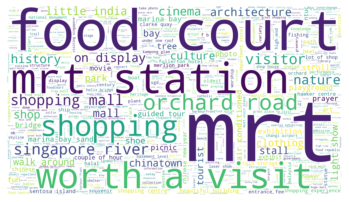

In [33]:
tripa_aspects_wordcloud = get_wordcloud(tripa_aspect_frequency)
tripa_aspects_wordcloud.to_file('./tripadvisor/aspects/tripa_wordclouds/tripa_aspects_wordcloud.png')

In [3]:
keywords_col_names = [
  "WEBSITE_ID", 
  "REVIEW_ID", 
  "TEXT", 
  "RELEVANCE", 
  "COUNT", 
  "SENTIMENT_SCORE", 
  "SENTIMENT_LABEL", 
  "SADNESS", 
  "JOY", 
  "FEAR", 
  "DISGUST", 
  "ANGER", 
  "MIXED_SENTIMENT"
]

tripa_ibm_keywords_path = './tripadvisor/finalised_output/'
tripa_ibm_keywords_folders = os.listdir(tripa_ibm_keywords_path)
tripa_ibm_keywords_folders

tripa_ibm_keywords_df = pd.DataFrame(columns = keywords_col_names)

for folder in tripa_ibm_keywords_folders:
    sub_folders = os.listdir(tripa_ibm_keywords_path + folder)
    folder_2 = [f for f in sub_folders if f.find('sentiments') != -1][0]
    path = tripa_ibm_keywords_path + folder + "/" + folder_2 + "/"
    keywords_csvs = [x for x in os.listdir(path) if x.find('keywords') != -1]
    for csv in keywords_csvs:
        tripa_ibm_keywords_df = tripa_ibm_keywords_df.append(
            pd.read_csv(path + csv), 
            ignore_index=True
        )

tripa_ibm_keywords_df.drop_duplicates(["REVIEW_ID", "TEXT"], inplace=True)
tripa_ibm_keywords_df.shape

(1395759, 13)

In [10]:
# tripa_ibm_keywords_df.iloc[:350000,:].to_csv('./aspects/tripa_ibm_keywords_df_1.csv')
# tripa_ibm_keywords_df.iloc[350000:700000,:].to_csv('./aspects/tripa_ibm_keywords_df_2.csv')
# tripa_ibm_keywords_df.iloc[700000:1050000,:].to_csv('./aspects/tripa_ibm_keywords_df_3.csv')
# tripa_ibm_keywords_df.iloc[1050000:,:].to_csv('./aspects/tripa_ibm_keywords_df_4.csv')

In [36]:
tripa_ibm_keywords_frequency = get_frequency(
    tripa_ibm_keywords_df, 
    'TEXT')

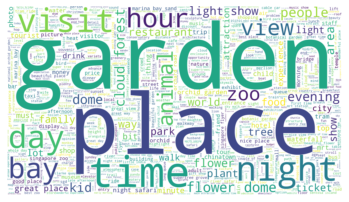

In [37]:
tripa_ibm_keywords_wordcloud = get_wordcloud(tripa_ibm_keywords_frequency)
tripa_ibm_keywords_wordcloud.to_file('./tripadvisor/aspects/tripa_wordclouds/tripa_ibm_keywords_wordcloud.png')

In [11]:
reviews_col_names = [
    'REVIEW_INDEX',
    'WEBSITE_INDEX',
    'POI_INDEX',
    'REVIEWER_URL',
    'REVIEW_ID',
    'REVIEW_DATE',
    'REVIEW_RATING',
    'REVIEW_TITLE',
    'REVIEW_BODY',
    'DATE_OF_EXPERIENCE',
    'TRIP_TYPE',
    'REVIEW_CRAWLED_TIME'
]

tripa_reviews_path = './tripadvisor/finalised_output/'
tripa_reviews_folders = os.listdir(tripa_reviews_path)
tripa_reviews_folders

tripa_reviews_df = pd.DataFrame(columns = reviews_col_names)

for folder in tripa_reviews_folders:
    path = tripa_reviews_path + folder + '/reviews/'
    reviews_csvs = os.listdir(path)
    for csv in reviews_csvs:
        tripa_reviews_df = tripa_reviews_df.append(
            pd.read_csv(path + csv), 
            ignore_index=True
        )

tripa_reviews_df.drop_duplicates("REVIEW_ID", inplace=True)
tripa_reviews_df.shape

(129600, 12)

In [12]:
# tripa_reviews_df.iloc[:60000,:].to_csv('./aspects/tripa_reviews_merged_1.csv')
# tripa_reviews_df.iloc[60000:,:].to_csv('./aspects/tripa_reviews_merged_2.csv')

In [40]:
tripa_review_body_frequency = get_ngram_frequency(
    tripa_reviews_df, 
    'REVIEW_BODY', 
    stop_words, 
    n=3)

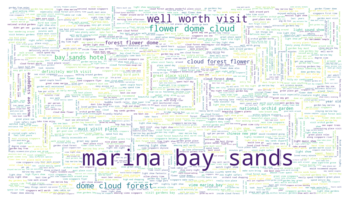

In [41]:
tripa_review_body_wordcloud = get_wordcloud(tripa_review_body_frequency)
tripa_review_body_wordcloud.to_file('./tripadvisor/aspects/tripa_wordclouds/tripa_review_body_wordcloud_3.png')

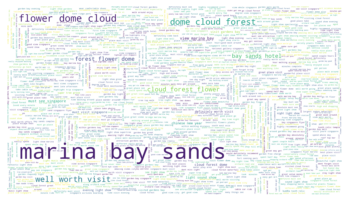

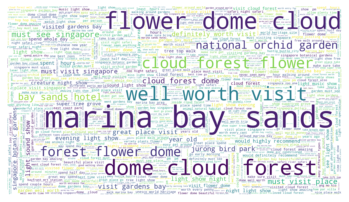

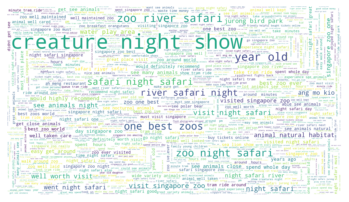

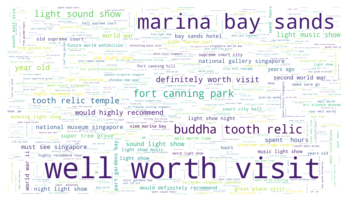

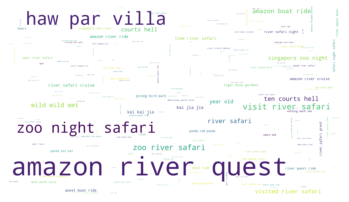

In [42]:
for attraction_type in attraction_types:
    relevant_pois = []
    for i in range(tripa_poi_attraction_types.shape[0]):
        row = tripa_poi_attraction_types.iloc[i,:]
        if row[1] == attraction_type:
            relevant_pois.append(row[0])
    relevant_df = pd.DataFrame(columns=reviews_col_names)
    for poi in relevant_pois:
        temp_df = tripa_reviews_df[tripa_reviews_df.POI_INDEX == poi]
        relevant_df = relevant_df.append(temp_df, ignore_index=True)
    
    if relevant_df.shape[0] == 0:
        continue
    
    frequency_df = get_ngram_frequency(
        relevant_df, 
        'REVIEW_BODY', 
        stop_words, 
        n=3)
    
    relevant_df_wordcloud = get_wordcloud(frequency_df)
    
    relevant_df_wordcloud.to_file('./tripadvisor/aspects/tripa_wordclouds/tripa_{}_wordcloud_3.png'.format(attraction_type))

In [54]:
## Create corpus from review text
reviews_text = list(tripa_reviews_df.REVIEW_BODY)
lemmatizer = WordNetLemmatizer()

for i in range(len(reviews_text)):
    output = []
    temp = reviews_text[i].replace('\n', ' ')
    temp = str(temp)
    temp = re.sub('[^0-9a-zA-Z ]+', '', temp)
    temp = temp.lower().split(' ')
    for word in temp:
        if word not in stop_words:
            word = lemmatizer.lemmatize(word)
            output.append(word)
    reviews_text[i] = ' '.join(output)

with open('./aspects/tripa_corpus.txt', 'w') as filehandle:
    filehandle.writelines("{}\n".format(review) for review in reviews_text)
    
filehandle.close()

In [56]:
## Create corpus from review text
reviews_text = list(tripa_reviews_df.REVIEW_BODY)

for i in range(len(reviews_text)):
    output = []
    temp = reviews_text[i].replace('\n', ' ')
    reviews_text[i] = temp

with open('./aspects/tripa_corpus.txt', 'w') as filehandle:
    filehandle.writelines("{}\n".format(review) for review in reviews_text)
    
filehandle.close()

In [4]:
tripa_ibm_keywords_df.head()

,WEBSITE_ID,REVIEW_ID,TEXT,RELEVANCE,COUNT,SENTIMENT_SCORE,SENTIMENT_LABEL,SADNESS,JOY,FEAR,DISGUST,ANGER,MIXED_SENTIMENT
0,1,735525393,Sengkang pool,0.890332,1,-0.643313,negative,0.390359,0.145347,0.276201,0.056802,0.348548,NaN
1,1,735525393,Great value,0.851443,1,0.962888,positive,0.043268,0.819987,0.011432,0.018376,0.020945,NaN
2,1,735525393,Full mini township services,0.651328,1,0.000000,neutral,0.133610,0.234355,0.020832,0.172570,0.092278,NaN
3,1,735525393,year olds,0.623779,1,0.000000,neutral,0.102725,0.017456,0.909710,0.127389,0.049980,NaN
4,1,735525393,Great dad son outing,0.622653,1,0.964044,positive,0.080753,0.838833,0.027096,0.009101,0.018644,NaN


In [25]:
%%time
## Create corpus from ibm text, and write to file 

review_ids = [i for i in set(tripa_ibm_keywords_df.REVIEW_ID)]

def lower(string):
    return string.lower()

def replace_spacing(string):
    return string.replace(' ', '_')

df = tripa_ibm_keywords_df[['REVIEW_ID', 'TEXT']].copy()
df.TEXT = df.TEXT.apply(str).apply(lower).apply(replace_spacing)

final_df = df.groupby('REVIEW_ID').aggregate(' '.join)
text_list = list(final_df.TEXT)

with open('./tripadvisor/aspects/tripa_ibm_corpus.txt', 'w') as filehandle:
    filehandle.writelines("{}\n".format(text) for text in all_text)
filehandle.close()

final_df

CPU times: user 3.12 s, sys: 27.8 ms, total: 3.15 s
Wall time: 3.17 s


,TEXT
REVIEW_ID,
336292249,sky_park spur_of_the_moment_thing highlight_of...
336295777,late_afternoon different_areas range_of_activi...
336299068,great_mixture_of_different_types_of_gardens su...
336304122,great_view_of_singapore raffles crowds singapo...
336305805,spare_hours beautiful_spot singapore
...,...
741865751,iconic_shopping_street chinese_new_year people...
741866029,plaza_singapura dhoby_ghuat_mrt_station major_...
741879478,chinese_new_year tian_tian_chicken_rice long_d...
